In [2]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import sys
sys.path.append('../python/')
import gis_functions as gf
import lem
import pandas as pd
from gis_functions import generate_pour_point_catchment
from shapely.geometry import shape
from rasterio.features import shapes
import geopandas as gpd
%load_ext autoreload
%autoreload 2

In [3]:
pts = gpd.read_file('/Users/gr_1/Downloads/crn_int_outlets_4326')
bain = gpd.read_file('/Users/gr_1/Downloads/crn_int_4326')


In [5]:
pts = pts.set_index('OBSID1')
pts = pts.reindex(bain['OBSID1'])
pts.index = np.arange(len(pts))
Areas = bain.geometry.area

/var/folders/5v/804c95h92bx2zr8rfpwyr_yc0000gn/T/ipykernel_1577/2235362367.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  Areas = bain.geometry.area


In [6]:

for num in range(G[2],G[2]+1):
    pt = [pts.loc[num].geometry.xy[1][0], pts.loc[num].geometry.xy[0][0]]
    filenm = f'/Volumes/LaCie/alldems/glob_bas_hydroshed_{str(num)}_.tif'
    outnm = f'/Volumes/LaCie/dems_clipped/glob_bas_hydroshed_{str(num)}_.tif'
    try:
        f = rio.open(filenm) #File containing DEM
    except:
        print('no file: ' + str(num))
        continue
    #fig,ax = plt.subplots(1,1)

    Z=np.float64(np.squeeze(f.read()))
    m,n = np.shape(Z)
    lat = np.array([f.xy(i,0)[1] for i in range(m)])
    lon = np.array([f.xy(0,i)[0] for i in range(n)])

    #plt.pcolormesh(lon, lat, Z, cmap='terrain')
    dem=lem.simple_model()

    Z[np.isnan(Z)] = -9999
    dem.set_z(Z)
    dem.dy = np.mean(np.diff(lon)) * 111000
    dem.dx =  np.cos(np.abs(np.mean(lat))/180*np.pi) * (1852/60)
    dem.sinkfill()
    Z=dem.get_z().copy()
    Z[Z<=0] = np.nan
    dem.set_z(Z)
    dem.slp()
    dem.stack()
    dem.acc()
    A = dem.A
    athres = 100 #threshold drainage area for plotting
    IJ = np.where((A>athres) & (Z>=1))
    #plt.plot(lon[IJ[1]],lat[IJ[0]],'.k',markersize=.1)
    #plt.plot(pt[1],pt[0],'.r',markersize=3)
    Area1 = Areas[num] * 3600**2 * dem.dx*dem.dy
    try:
        df,_ = generate_pour_point_catchment(filenm, outnm, pt, fillsink=True, target_area=Area1, search_area=.1, flowdir=None)
    except Exception as e:
        print(e)
    df.to_file(f'../dfs/bound_{num}')
    #df.plot(ax=ax,color='red')


NameError: name 'G' is not defined

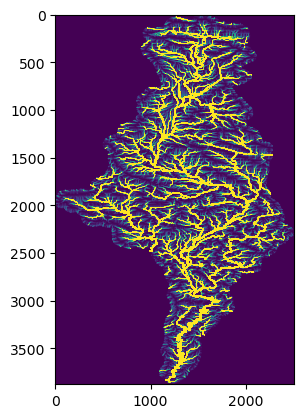

In [101]:
plt.imshow(dem.A,vmax=300)


In [7]:
areas=[]
for num in range(0,6000):
    filenm = f'/Volumes/LaCie/dfs/bound_{str(num)}'
    try:
        f = gpd.read_file(filenm) #File containing DEM
        areas.append(f.geometry.area[0])
        print(num)
    except:
        areas.append(np.nan)


124
139
140
144
145
146
147
148
149
150
151
152
153
156
157
163
168
173
175
191
192
193
194
195
196
197
198
199
200
201
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
231
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
301
302
303
304
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
327
328
332
333
334
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
443
452
495
496
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549


In [17]:
Areas

0       0.026067
1       0.028561
2       0.029701
3       0.026521
4       0.020430
          ...   
5371    0.000041
5372    0.000026
5373    0.000034
5374    0.000034
5375    0.000033
Length: 5376, dtype: float64

(0.5, 1.5)

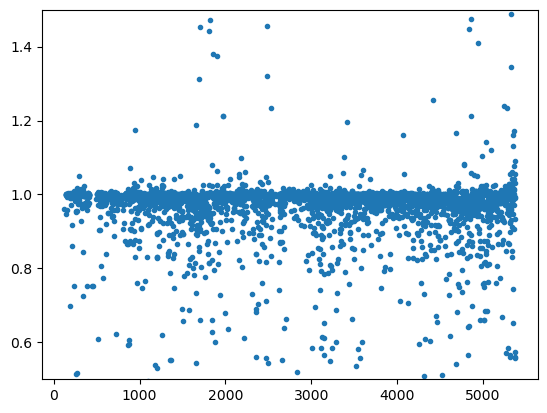

In [23]:
plt.plot((areas[:len(Areas)])/Areas,'.')
plt.ylim([.5,1.5])

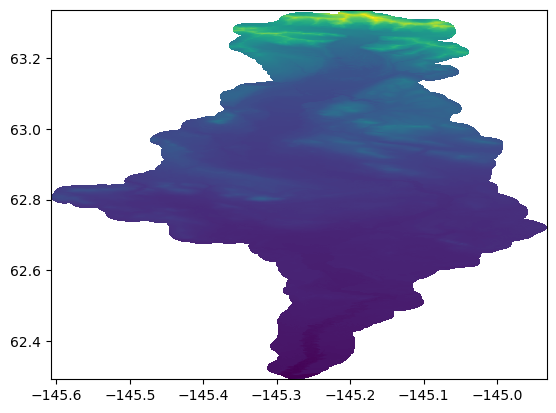

In [92]:
i=2
fig,ax = plt.subplots(1,1)
R = rio.open(f'/Volumes/LaCie/alldems/glob_bas_hydroshed_{G[i]}_.tif')

G2 = gpd.read_file(f'/Volumes/LaCie/dfs/bound_{G[i]}')
dem=R.read(1)
m,n = np.shape(dem)
x = [R.xy(0,i)[0] for i in range(n)]
y = [R.xy(i,0)[1] for i in range(m)]
#X,Y = np.meshgrid(x,y)
ax.pcolormesh(x,y,dem)
#G2.plot(ax=ax)



## " B sides "

In [135]:
for num in range(G[2],G[2]+1):
    pt = [pts.loc[num].geometry.xy[1][0], pts.loc[num].geometry.xy[0][0]]
    filenm = f'/Volumes/LaCie/alldems/glob_bas_hydroshed_{str(num)}_.tif'
    outnm = f'/Volumes/LaCie/dems_clipped/glob_bas_hydroshed_{str(num)}_.tif'
    try:
        f = rio.open(filenm) #File containing DEM
    except:
        print('no file: ' + str(num))
        continue
    #fig,ax = plt.subplots(1,1)

    Z=np.float64(np.squeeze(f.read()))
    m,n = np.shape(Z)
    lat = np.array([f.xy(i,0)[1] for i in range(m)])
    lon = np.array([f.xy(0,i)[0] for i in range(n)])

    #plt.pcolormesh(lon, lat, Z, cmap='terrain')
    dem=lem.simple_model()

    Z[np.isnan(Z)] = -9999
    dem.set_z(Z)
    dem.dy = np.mean(np.diff(lon)) * 111000
    dem.dx =  np.cos(np.abs(np.mean(lat))/180*np.pi) * (1852/60)
    dem.sinkfill()
    Z=dem.get_z().copy()
    Z[Z<=0] = np.nan
    dem.set_z(Z)
    dem.slp()
    dem.stack()
    dem.acc()
    A = dem.A
    athres = 100 #threshold drainage area for plotting
    IJ = np.where((A>athres) & (Z>=1))
    #plt.plot(lon[IJ[1]],lat[IJ[0]],'.k',markersize=.1)
    #plt.plot(pt[1],pt[0],'.r',markersize=3)
    Area1 = Areas[num] * 3600**2 * dem.dx*dem.dy
    #try:
    df,_ = generate_pour_point_catchment(filenm, outnm, pt, fillsink=True, target_area=Area1, search_area=.1, flowdir=None)
    #except Exception as e:
        #print(e)
    df.to_file(f'../dfs/bound_{num}')
    #df.plot(ax=ax,color='red')

resetting
Boundary condition values have been reset
resetting
Boundary condition values have been reset
dx=-24.588096067061404
Filling DEM
62.310841691376304
62.29246065163466
0
1512743243.7384803
here
2409042714.9464912
(3831, 1162.0)
writink


/Users/gr_1/Documents/ks_total/notebooks/../python/gis_functions.py:164: RuntimeWarning: invalid value encountered in cast
  


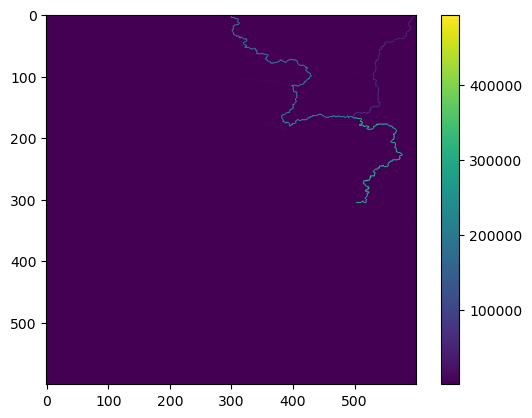

In [134]:
res=300
plt.imshow(dem.A[2477-res:2477+res,796-res:796+res])
plt.colorbar()

In [27]:
# Format flow dir raster -
# raster is in relative direction format 1 = E, 2 = SE, 4=S, 8=SW, 16 = W, 32 =NW, 64 =N, 128 = NE
# We must revise it so that it is in the format of the receiver grid - absolute (row major) location

R = rio.open('/users/gr_1/Downloads/clipped_flow.tif')
flowdir = np.squeeze(R.read())
ny,nx = np.shape(flowdir)
flowdir_revised = np.zeros((ny,nx))
flowdir_revised[flowdir==1]=ny
flowdir_revised[flowdir==2]=ny+1
flowdir_revised[flowdir==4]=1
flowdir_revised[flowdir==8]=-ny+1
flowdir_revised[flowdir==16]=-ny
flowdir_revised[flowdir==32]=-ny-1
flowdir_revised[flowdir==64]=-1
flowdir_revised[flowdir==128]=ny-1
add_vec = np.arange(ny*nx).reshape(ny,nx,order='F')
flowdir_revised+=add_vec
flowdir_revised[flowdir_revised<0]=0
flowdir_revised[0,:]=add_vec[0,:]
flowdir_revised[-1,:]=add_vec[-1,:]
flowdir_revised[:,0]=add_vec[:,0]
flowdir_revised[:,-1]=add_vec[:,-1]
flowdir_revised=np.int64(flowdir_revised)

In [24]:
filenm = '/Users/gr_1/Downloads/clipped_dem.tif'
outnm =  '/Users/gr_1/Downloads/out_aus' #output for DEM
pt = [-23.986083, 134.7173]
df,A=generate_pour_point_catchment(filenm, outnm, pt,
                                   fillsink=False,
                                   target_area = 1e8,
                                   search_area =.05,flowdir=flowdir_revised)


NameError: name 'flowdir_revised' is not defined

<Axes: >

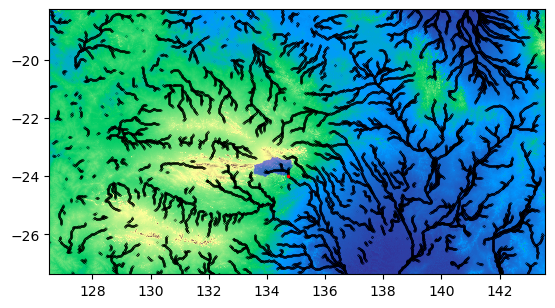

In [13]:
fig,ax = plt.subplots(1,1)
f = rio.open(filenm) #File containing DEM
Z=np.float64(np.squeeze(f.read()))
m,n = np.shape(Z)
lat = np.array([f.xy(i,0)[1] for i in range(m)])
lon = np.array([f.xy(0,i)[0] for i in range(n)])
plt.pcolormesh(lon,lat,Z,cmap='terrain')
athres = 10000 #threshold drainage area for plotting
IJ = np.where((A>athres) & (Z>=1))
plt.plot(lon[IJ[1]],lat[IJ[0]],'.k',markersize=.1)
plt.plot(pt[1],pt[0],'.r',markersize=3)
df.plot(ax=ax,color='blue',alpha=.5)



In [32]:
pts.iloc[100:103]

,OBSID1,OBSID2,STUDYID,geometry
100,S069WTS022,Novate,S069,POINT (9.45954 46.41203)
101,S069WTS023,Oglio,S069,POINT (10.34916 46.35119)
102,S069WTS024,Pfitsch,S069,POINT (11.47359 47.09398)


In [66]:
shps.iloc[101].geometry.bounds

(97.33914413779921, 39.49293985728793, 97.57081572040957, 39.87183086758495)

In [116]:
pts.iloc[615]

OBSID1                                        S095WTS006
OBSID2                                          QS-JG-43
STUDYID                                             S095
geometry    POINT (99.27335274048113 39.016331511204974)
Name: 615, dtype: object

x## Global

In [106]:
i=15
filenm = f'../data_earth_engine/nz_bas_hydroshed_{i}_.tif' #input file name for DEM
outnm = f'../data_earth_engine/nz_bas_hydroshed_{i}_output' #output for DEM
ptfile = './octo_points'
shpfile = '../Archive/crn_int_basins_071625'

if 0:
        pts = gpd.read_file(ptfile)
        pts=pts.to_crs('epsg:4326')
if 0:
        shps = gpd.read_file(shpfile)
        shps=shps.to_crs('epsg:4326')
xy =[pts.iloc[i].geometry.xy[0][0],pts.iloc[i].geometry.xy[1][0]]



In [113]:
pts.iloc[13:17]

,OBSID1,OBSID2,STUDYID,geometry
13,S076WTS001,Arr_2,S076,POINT (84.97039 27.96629)
14,S274WTS016,16PH005,S274,POINT (-145.73919 63.50637)
15,S082WTS015,Boo-M3,S082,POINT (-66.04359 -26.77025)
16,S086WTS004,NEP065,S086,POINT (84.42983 28.14677)


[547, 511]
500 500
(547, 511)
Boundary condition values have been reset
dx=26.7077215895671
Filling DEM
[547, 511]
547 511
(547, 511)
1074
-66.0435878636774
38.919734263299304


ValueError: zero-size array to reduction operation maximum which has no identity

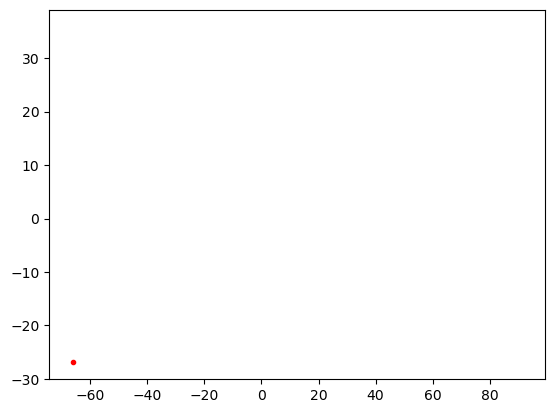

In [109]:
df,A=generate_pour_point_catchment(filenm, outnm, xy, target_area = 10, search_area =.01)

In [6]:
import jupydebug as jdb

In [95]:

frames2 = jdb.post_mortem()

In [96]:
acc = frames2[3].locals['acc']

In [97]:
w = frames2[3].locals['w']
y = frames2[3].locals['y']
x = y = frames2[3].locals['x']

In [98]:
acc[y-w:y+w+1,x-w:x+w+1]

np.shape(acc)

(747, 922)

In [110]:
xy

[-66.0435878636774, -26.770249953266188]

In [78]:
ny, nx = np.where(acc[y-w:y+w+1,x-w:x+w+1]>= np.max(acc[y-w:y+w+1,x-w:x+w+1])/1.25)

ValueError: zero-size array to reduction operation maximum which has no identity

In [12]:
frames2[3][

AttributeError: 'Frame' object has no attribute 'acc'

In [125]:
m,n = np.shape(Z)
x,y = np.meshgrid(np.arange(n),np.arange(m))

In [126]:
nans = np.isnan(Z.ravel())

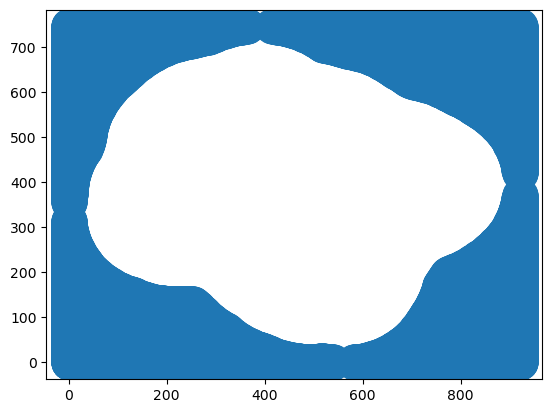

In [96]:
plt.plot(x.ravel()[nans],y.ravel()[nans],'.',markersize=50)